In [848]:
import sqlite3
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [849]:
RT_LIMIT_LOWER = 4340  # RT range in the database
RT_LIMIT_UPPER = 4580
RT_BASE_PEAK_WIDTH_SECS = 30.0  # assumption about base peak width in RT
MS1_CE = 10

In [850]:
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
ALLPEPTIDES_FILENAME = '/Users/darylwilding-mcbride/Downloads/maxquant_results/txt/allPeptides.txt'
# BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
# ALLPEPTIDES_FILENAME = '/home/ubuntu/maxquant_results/txt/allPeptides.txt'

CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [851]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-4340-4580/HeLa_20KInt.sqlite'

In [852]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
ms2_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy <> {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
db_conn.close()

In [853]:
ms1_frame_properties_df.head()

,frame_id,retention_time_secs
0,40411,4340.340330
1,40422,4341.521415
2,40433,4342.702923
3,40444,4343.883324
4,40455,4345.067491


In [854]:
ms2_frame_properties_df.head()

,frame_id,retention_time_secs
0,40408,4340.019894
1,40409,4340.127084
2,40410,4340.233855
3,40412,4340.446655
4,40413,4340.554812


In [855]:
ms1_frame_delay = ms1_frame_properties_df.iloc[1].retention_time_secs - ms1_frame_properties_df.iloc[0].retention_time_secs
ms1_frame_delay

1.1810854877303427

In [856]:
len(ms1_frame_properties_df)

203

In [857]:
# get all the isolation windows
isolation_window_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df.pkl')

In [858]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,CollisionEnergy,Precursor
0,3,507,532,742.744835,2.427448,36.96,1
1,3,549,574,709.235759,2.092358,36.96,2
2,3,602,627,594.235088,2.000000,36.96,3
3,3,643,668,503.527768,2.000000,36.96,4
4,3,684,709,552.063870,2.000000,31.92,5


In [859]:
# add-in the retention time for the isolation windows and filter out the window not in range
isolation_window_df = pd.merge(isolation_window_df, ms2_frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)
isolation_window_df.dropna(subset=['retention_time_secs'], inplace=True)
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2)
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2)
isolation_window_df['rt_lower'] = isolation_window_df.retention_time_secs - RT_BASE_PEAK_WIDTH_SECS
isolation_window_df['rt_upper'] = isolation_window_df.retention_time_secs + RT_BASE_PEAK_WIDTH_SECS

In [860]:
# filter out isolation windows that don't fit in the database subset we have loaded
isolation_window_df = isolation_window_df[(isolation_window_df.rt_lower >= RT_LIMIT_LOWER) & (isolation_window_df.rt_upper <= RT_LIMIT_UPPER)]

In [861]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper,rt_lower,rt_upper
315657,40688,219,244,1106.675230,3.0,148941,4370.101926,1105.175230,1108.175230,4340.101926,4400.101926
315658,40688,287,312,987.488407,3.0,148938,4370.101926,985.988407,988.988407,4340.101926,4400.101926
315659,40688,344,369,922.491024,3.0,148930,4370.101926,920.991024,923.991024,4340.101926,4400.101926
315660,40688,386,411,884.941548,3.0,148942,4370.101926,883.441548,886.441548,4340.101926,4400.101926
315661,40688,434,459,876.400632,3.0,148943,4370.101926,874.900632,877.900632,4340.101926,4400.101926


Select one of the precursors

In [862]:
print("There are {} precursor isolation windows.".format(len(isolation_window_df)))

There are 17860 precursor isolation windows.


In [863]:
ISOLATION_WINDOW_IDX = 11530
window_df = isolation_window_df.iloc[ISOLATION_WINDOW_IDX]

In [864]:
# PRECURSOR_ID = 154951
# window_df = isolation_window_df[isolation_window_df.Precursor == PRECURSOR_ID].iloc[0]

In [865]:
window_df

Frame                   41756.000000
ScanNumBegin              578.000000
ScanNumEnd                603.000000
IsolationMz               793.573708
IsolationWidth              2.935737
Precursor              154951.000000
retention_time_secs      4484.817465
mz_lower                  792.105840
mz_upper                  795.041577
rt_lower                 4454.817465
rt_upper                 4514.817465
Name: 327187, dtype: float64

In [866]:
mz_lower = window_df.mz_lower
mz_upper = window_df.mz_upper
scan_width = int(window_df.ScanNumEnd - window_df.ScanNumBegin)
scan_lower = int(window_df.ScanNumBegin - scan_width)
scan_upper = int(window_df.ScanNumEnd + scan_width)
rt_lower = window_df.rt_lower
rt_upper = window_df.rt_upper
precursor_id = int(window_df.Precursor)

In [867]:
# get the ms1 frame IDs
ms1_frame_ids = tuple(ms1_frame_properties_df.astype(int).values[:,0])


In [868]:
# load the cube's raw ms1 points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(mz_lower, mz_upper, scan_lower, scan_upper, rt_lower, rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [869]:
len(raw_points_df)

9226

In [870]:
raw_points_df.intensity.max()

378

In [871]:
raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
0,41478,792.153351,576,48,4454.986745
1,41478,792.171103,625,9,4454.986745
2,41478,792.202169,557,64,4454.986745
3,41478,792.313124,622,54,4454.986745
4,41478,792.330878,565,99,4454.986745


In [872]:
MZ_MIN = mz_lower
MZ_MAX = mz_upper
MZ_BIN_WIDTH = 0.1

In [873]:
bins = np.arange(start=MZ_MIN, stop=MZ_MAX+MZ_BIN_WIDTH, step=MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [874]:
bins

array([792.10583988, 792.20583988, 792.30583988, 792.40583988,
       792.50583988, 792.60583988, 792.70583988, 792.80583988,
       792.90583988, 793.00583988, 793.10583988, 793.20583988,
       793.30583988, 793.40583988, 793.50583988, 793.60583988,
       793.70583988, 793.80583988, 793.90583988, 794.00583988,
       794.10583988, 794.20583988, 794.30583988, 794.40583988,
       794.50583988, 794.60583988, 794.70583988, 794.80583988,
       794.90583988, 795.00583988, 795.10583988])

In [875]:
MZ_BIN_COUNT = len(bins)

In [876]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
mz_values_array = np.empty(MZ_BIN_COUNT, dtype=np.object)
for idx in range(MZ_BIN_COUNT):
    mz_values_array[idx] = []


In [877]:
# gather the m/z values into bins
for r in zip(raw_points_df.mz, raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= MZ_MIN) and (mz <= MZ_MAX): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, bins)) # in which bin should this mz go
        mz_values_array[mz_array_idx].append((mz, intensity))

In [878]:
import peakutils

In [879]:
# compute the intensity-weighted m/z centroid and the summed intensity of the bins
peaks = []
for bin_idx in range(MZ_BIN_COUNT):
    if len(mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        peaks.append((mz_centroid,summed_intensity))

In [880]:
peaks

[(792.1462195640484, 5296),
 (792.2651894510926, 4244),
 (792.3649433922126, 56196),
 (792.4323523753229, 10465),
 (792.5758466653931, 12143),
 (792.6679714215314, 17947),
 (792.7352402320125, 24091),
 (792.8514102004323, 13926),
 (792.962298415924, 7856),
 (793.05984062467, 30879),
 (793.129205392452, 19652),
 (793.2698032904228, 4058),
 (793.3718039915751, 67059),
 (793.4376605105524, 7741),
 (793.5720850639026, 8028),
 (793.6386740684461, 33933),
 (793.733621486158, 41745),
 (793.862688170821, 24440),
 (793.9655833959639, 6200),
 (794.0577009335708, 37473),
 (794.1252658939972, 14557),
 (794.2601236589568, 3259),
 (794.36730728319, 41353),
 (794.4404377366116, 9315),
 (794.5734604769322, 11629),
 (794.6678304599117, 12833),
 (794.7322388992521, 22741),
 (794.8529408535119, 13586),
 (794.9672566368995, 5223),
 (795.0269335449691, 9614)]

In [881]:
peaks_df = pd.DataFrame(peaks, columns=['mz_centroid','summed_intensity'])

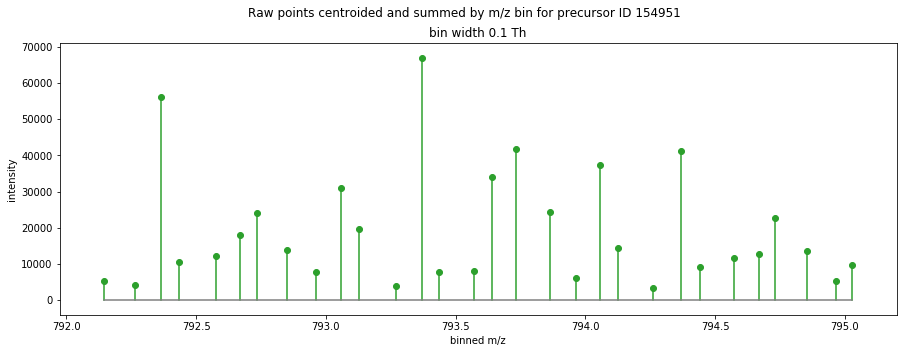

In [882]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(peaks_df.mz_centroid, peaks_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

In [883]:
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.


In [884]:
from ms_deisotope import deconvolute_peaks, averagine, scoring

# see https://github.com/mobiusklein/ms_deisotope/blob/ee4b083ad7ab5f77722860ce2d6fdb751886271e/ms_deisotope/deconvolution/api.py#L17
deconvoluted_peaks, _priority_targets = deconvolute_peaks(peaks, averagine=averagine.peptide, scorer=scoring.MSDeconVFitter(10.0))


In [885]:
peaks_l = []
for peak in deconvoluted_peaks:
    peaks_l.append((peak.mz, peak.neutral_mass, peak.intensity, peak.score, peak.signal_to_noise))
deconvoluted_peaks_df = pd.DataFrame(peaks_l, columns=['mz','neutral_mass','intensity','score','SN'])
# 'neutral mass' is the zero charge M, so we add the proton mass to get M+H (the monoisotopic mass)
deconvoluted_peaks_df['m_plus_h'] = deconvoluted_peaks_df.neutral_mass + PROTON_MASS


In [886]:
deconvoluted_peaks_df

,mz,neutral_mass,intensity,score,SN,m_plus_h
0,792.266448,791.259172,11561.000000,73.547932,3853.666667,792.266472
1,792.364943,791.357667,111527.809109,296.291195,54869.333333,792.364967
2,792.434306,791.427029,27521.000000,139.231470,9173.666667,792.434329
3,792.575847,791.568570,17549.907610,114.159765,11886.000000,792.575870
4,792.667971,791.660695,30780.000000,139.290606,15390.000000,792.667995
5,792.851410,791.844134,27512.000000,109.342633,13756.000000,792.851434
6,792.962298,791.955022,19279.000000,130.399466,6426.333333,792.962322
7,793.733621,792.726345,64486.000000,297.102556,32243.000000,793.733645
8,793.059841,1584.105128,88009.000000,251.549113,22002.250000,1585.112428
9,793.120965,3168.454755,167061.000000,437.114703,33412.200000,3169.462055


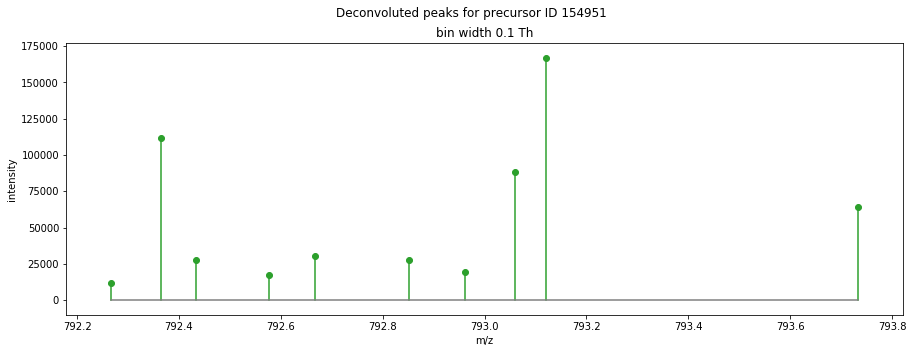

In [887]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(deconvoluted_peaks_df.mz, deconvoluted_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Deconvoluted peaks for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

In [888]:
# assume the high score is for the monoisotopic peak
monoisotopic_mz = deconvoluted_peaks_df.iloc[deconvoluted_peaks_df.score.idxmax()].mz

In [889]:
monoisotopic_mz

793.1209652821251

In [890]:
monoisotopic_bin = int(np.digitize(monoisotopic_mz, bins))

Get the raw points for the monoisotopic peak

In [891]:
MZ_TOLERANCE_PPM = 20
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [892]:
monoisotopic_mz_ppm_tolerance = monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100
monoisotopic_mz_lower = monoisotopic_mz - monoisotopic_mz_ppm_tolerance
monoisotopic_mz_upper = monoisotopic_mz + monoisotopic_mz_ppm_tolerance

In [893]:
monoisotopic_raw_points_df = raw_points_df[(raw_points_df.mz >= monoisotopic_mz_lower) & (raw_points_df.mz <= monoisotopic_mz_upper)]

In [894]:
monoisotopic_raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
33,41478,793.116674,561,82,4454.986745
34,41478,793.121114,559,73,4454.986745
216,41489,793.116674,562,58,4456.163586
448,41500,793.121114,597,12,4457.345016
739,41511,793.112233,559,87,4458.525167


Collapsing the summed points onto the RT dimension

In [895]:
rt_df = monoisotopic_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_df

,frame_id,retention_time_secs,intensity
0,41478,4454.986745,155
1,41489,4456.163586,58
2,41500,4457.345016,12
3,41511,4458.525167,87
4,41533,4460.882660,169
5,41566,4464.423259,68
6,41577,4465.608514,123
7,41588,4466.791048,65
8,41610,4469.151401,73
9,41621,4470.328991,260


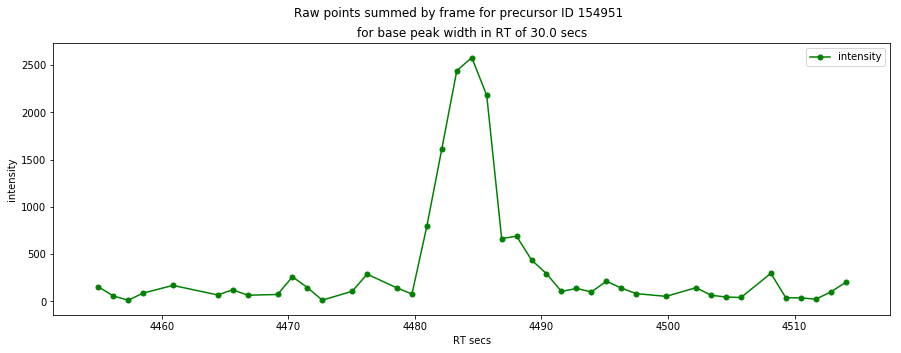

In [896]:
f, ax = plt.subplots()
ax.plot(rt_df.retention_time_secs, rt_df.intensity, marker='o', color='green', linestyle='-', ms=5)
# plt.axvline(x=RT_LIMIT_LOWER, linestyle=':', color='tab:red')
# plt.axvline(x=RT_LIMIT_UPPER, linestyle=':', color='tab:red')
plt.legend(loc='best')
plt.xlabel('RT secs')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points summed by frame for precursor ID {}'.format(precursor_id))
plt.title('for base peak width in RT of {} secs'.format(RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()

Collapsing the summed points onto the mobility dimension

In [897]:
scan_df = monoisotopic_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_df

,scan,intensity
0,553,153
1,554,128
2,555,139
3,556,144
4,557,222
5,558,216
6,559,186
7,560,205
8,561,441
9,562,137


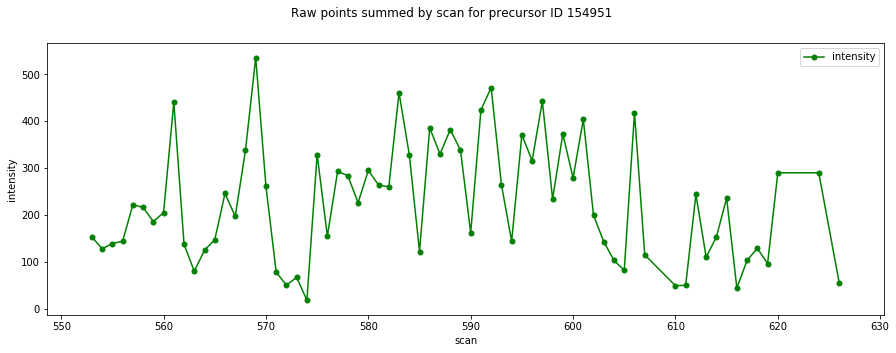

In [898]:
f, ax = plt.subplots()
ax.plot(scan_df.scan, scan_df.intensity, marker='o', color='green', linestyle='-', ms=5)
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points summed by scan for precursor ID {}'.format(precursor_id))
# plt.title('RT width {} secs'.format(2*RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()